# Data 분석
Data는 총 4 가지가 있다. 
- ADC (ADeno-Carcinoma)
- HGD (High-Grade Dysplasia)
- LGD (Low-Grade Dysplasia)
- NOR (Normal)

데이터의 생김새는 다음과 같다. Raw image와 masking이 된(labeled) image가 있다.
- data: <font color=yellow>\[phase\]\_IMG_[patient #].jpg</font>
- label: <font color=yellow>\[phase\]\_MASK_[patient #].jpg</font>

데이터들은 original data에서 검은 부분을 최대한 지운, 즉 cropped 된 상태이다. 
이미지의 사이즈는 다 달라서 resize를 해주어야 한다.

In [1]:
# Data visualize를 위한 imports
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
# GPU 한 개만 할당을 위함
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]="3"

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from configparser import Interpolation
from saveLoad import save, load
from sklearn.metrics import confusion_matrix
import seaborn as sn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

pd.set_option('display.max.colwidth', 30)

# 경로 설정하기
original_data_path = '/disk1/colonoscopy_dataset/cropped/' # ADC / HGD / LGD / NOR
base_dir = '/home/sundongk/Multiclass_classification'
data_dir = original_data_path
ckpt_dir = os.path.join(base_dir, "checkpoint")

# 각 이미지들이 속해 있는 경로
ADC_img_path = '/disk1/colonoscopy_dataset/cropped/ADC/'
HGD_img_path = '/disk1/colonoscopy_dataset/cropped/HGD/'
LGD_img_path = '/disk1/colonoscopy_dataset/cropped/LGD/'
NOR_img_path = '/disk1/colonoscopy_dataset/cropped/NOR/'

Device: cuda
Current cuda device: 0
Count of using GPUs: 1


In [2]:
# 가) 전체 파일 수, ADC data 수와 labeled data 수 확인

ADC_file_list = os.listdir(ADC_img_path) # ADC 전체 파일 목록
HGD_file_list = os.listdir(HGD_img_path) # HGD 전체 파일 목록
LGD_file_list = os.listdir(LGD_img_path) # LGD 전체 파일 목록
NOR_file_list = os.listdir(NOR_img_path) # NOR 전체 파일 목록

ADC_data_list = sorted([x for x in ADC_file_list if 'IMG' in x])        # ADC data 파일 목록
ADC_labeled_list = sorted([x for x in ADC_file_list if 'MASK' in x])   # ADC mask 파일 목록

HGD_data_list = sorted([x for x in HGD_file_list if 'IMG' in x])        # HGD data 파일 목록
HGD_labeled_list = sorted([x for x in HGD_file_list if 'MASK' in x])    # HGD mask 파일 목록

LGD_data_list = sorted([x for x in LGD_file_list if 'IMG' in x])        # LGD data 파일 목록
LGD_labeled_list = sorted([x for x in LGD_file_list if 'MASK' in x])    # LGD mask 파일 목록

NOR_data_list = sorted([x for x in NOR_file_list if 'IMG' in x])        # NOR data 파일 목록
NOR_labeled_list = sorted([x for x in NOR_file_list if 'MASK' in x])    # NOR mask 파일 목록

totalNum_list = [len(ADC_file_list), len(HGD_file_list), len(LGD_file_list), len(NOR_file_list)]
totalData_list = [len(ADC_data_list), len(HGD_data_list), len(LGD_data_list), len(NOR_data_list)]
totalMask_list = [len(ADC_labeled_list), len(HGD_labeled_list), len(LGD_labeled_list), len(NOR_labeled_list)]

data = [totalData_list, totalMask_list, totalNum_list]
table = pd.DataFrame(data = data, index = ['data #', 'mask data #', 'Total #'], columns = ['ADC', 'HGD', 'LGD', 'NOR'])

total_img_name_list = [ADC_data_list, HGD_data_list, LGD_data_list, NOR_data_list]
total_label_name_list = [ADC_labeled_list, HGD_labeled_list, LGD_labeled_list, NOR_labeled_list]

print(table)

              ADC   HGD   LGD   NOR
data #        504   500  1000  1000
mask data #   504   500  1000  1000
Total #      1008  1000  2000  2000


# Dataset 만들기

- Train, validation, test를 각각 8 : 1 : 1의 비율로 나누어 만든다. 
  - 총 데이터: 3004장 = (2403, 300, 301)
  - Train, validation의 batch size는 32로 하고, test의 batch size는 1로 한다.
- 현재 task는 <font color=yellow>classification이므로 label을 바이너리</font>로 만들어주어야 한다.
  - ADC: 0
  - HGD: 1
  - LGD: 2
  - NOR: 3
- 전처리 사항
  - 256*256으로 resize + Bilinear interpolation
  - random affine (shear=10, scale=(0.8, 1.2))
  - random horizontal flip()
  - 전체 데이터의 평균과 표준편차로 normalize (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [3]:
# 8 : 1 : 1
ADC_train_length = int(len(ADC_data_list)*0.8) # 403
HGD_train_length = int(len(HGD_data_list)*0.8) # 400
LGD_train_length = int(len(LGD_data_list)*0.8) # 800
NOR_train_length = int(len(NOR_data_list)*0.8) # 800 ----- total 2403

ADC_valid_length = int(len(ADC_data_list)*0.1) # 50
HGD_valid_length = int(len(HGD_data_list)*0.1) # 50
LGD_valid_length = int(len(LGD_data_list)*0.1) # 100
NOR_valid_length = int(len(NOR_data_list)*0.1) # 100 ----- total 300

ADC_test_length = len(ADC_data_list) - ADC_train_length - ADC_valid_length # 51
HGD_test_length = len(HGD_data_list) - HGD_train_length - HGD_valid_length # 50
LGD_test_length = len(LGD_data_list) - LGD_train_length - LGD_valid_length # 100
NOR_test_length = len(NOR_data_list) - NOR_train_length - NOR_valid_length # 100 ----- total 301

In [4]:
# Dataloader 구현
class Dataset(Dataset):
    def __init__(self, data_dir, transform=None, type=None):
        self.data_dir = data_dir; self.transform = transform; self.type = type

        lst_label = []; lst_input = []; target_input = []; target_label = []

        # if type=0, train mode
        if type == 0:
            target_input = (ADC_data_list[:ADC_train_length] + HGD_data_list[:HGD_train_length] 
                                + LGD_data_list[:LGD_train_length] + NOR_data_list[:NOR_train_length])
            target_label = [0]*ADC_train_length + [1]*HGD_train_length + [2]*LGD_train_length + [3]*NOR_train_length
        
        # if type=1, valid mode
        elif type == 1:
            target_input = (ADC_data_list[ADC_train_length : ADC_train_length + ADC_valid_length] 
                                + HGD_data_list[HGD_train_length : HGD_train_length + HGD_valid_length] 
                                + LGD_data_list[LGD_train_length : LGD_train_length + LGD_valid_length] 
                                + NOR_data_list[NOR_train_length : NOR_train_length + NOR_valid_length])
            target_label = [0]*ADC_valid_length + [1]*HGD_valid_length + [2]*LGD_valid_length + [3]*NOR_valid_length

        # if type=2, test mode
        else:
            target_input = (ADC_data_list[ADC_train_length+ADC_valid_length:] 
                                + HGD_data_list[HGD_train_length + HGD_valid_length:] 
                                + LGD_data_list[LGD_train_length + LGD_valid_length:] 
                                + NOR_data_list[NOR_train_length + NOR_valid_length:])
            target_label = [0]*ADC_test_length + [1]*HGD_test_length + [2]*LGD_test_length + [3]*NOR_test_length

        self.lst_label = target_label
        self.lst_input = target_input
    
    def __len__(self):
        return len(self.lst_label)
    
    def __getitem__(self, index):
        datapath = ''
        if 'ADC' in self.lst_input[index]: # 0
            datapath = os.path.join(self.data_dir, 'ADC')
        elif 'HGD' in self.lst_input[index]: # 1
            datapath = os.path.join(self.data_dir, 'HGD')
        elif 'LGD' in self.lst_input[index]: # 2
            datapath = os.path.join(self.data_dir, 'LGD')
        elif 'NOR' in self.lst_input[index]: # 3
            datapath = os.path.join(self.data_dir, 'NOR')
        
        input = Image.open(os.path.join(datapath, self.lst_input[index])).convert('RGB')
        if self.transform is not None:
            input = self.transform(input)

        data = {'input': input, 'label': self.lst_label[index]}

        return data

In [5]:
# 데이터셋의 평균과 표준편차 구하기
# dataset_train = Dataset(data_dir=original_data_path, transform=transforms.ToTensor(), type=0)
# full_loader = DataLoader(dataset_train, shuffle=False)

# N_CHANNELS = 3
# mean = torch.zeros(3)
# std = torch.zeros(3)

# for item in full_loader:
#     inputs = item['input']
#     for i in range(N_CHANNELS):
#         mean[i] += inputs[:,i,:,:].mean()
#         std[i] += inputs[:,i,:,:].std()
# mean.div_(len(dataset_train)) # tensor([0.5907, 0.3514, 0.2599])
# std.div_(len(dataset_train)) # tensor([0.2410, 0.1998, 0.1630])

In [6]:
batch_size = 32; test_batch_size = 1

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((256,256), interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406],
        #                          std=[0.229, 0.224, 0.225])
        transforms.Normalize(mean=[0.590, 0.351, 0.259],
                                 std=[0.241, 0.199, 0.163])
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406],
        #                          std=[0.229, 0.224, 0.225])
        transforms.Normalize(mean=[0.590, 0.351, 0.259],
                                 std=[0.241, 0.199, 0.163])
    ]),
    'test':
    transforms.Compose([
        transforms.Resize((256,256), interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406],
        #                          std=[0.229, 0.224, 0.225])
        transforms.Normalize(mean=[0.590, 0.351, 0.259],
                                 std=[0.241, 0.199, 0.163])
    ])
}

image_datasets = {
    'train': Dataset(data_dir=original_data_path, transform=data_transforms['train'], type=0),
    'validation': Dataset(data_dir=original_data_path, transform=data_transforms['validation'], type=1),
    'test': Dataset(data_dir=original_data_path, transform=data_transforms['test'], type=2) 
}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=8),
    'validation': DataLoader(image_datasets['validation'], batch_size=batch_size, shuffle=False, num_workers=8),
    'test': DataLoader(image_datasets['test'], batch_size=test_batch_size, shuffle=False, num_workers=8)
}

# Resnet50 + GradCAM

- Classification의 Grad-CAM을 각 Class activation map으로부터 추출하여 어떤 형상이 나오는지 알아보기
- 우선 classification 모델 성능 끌어올리기

In [7]:
from torchvision import models

model = models.resnet50(pretrained=True).to(device)

# # freeze
# for param in model.parameters():
#     param.requires_grad = False     

model.fc = nn.Sequential(
               nn.Linear(2048, 256),
               nn.ReLU(inplace=True),
               nn.Linear(256, 4)).to(device)

/home/sundongk/miniconda3/envs/test/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/sundongk/miniconda3/envs/test/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
from torchsummary import summary
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

# 다양한 loss 함수 정의와 학습 함수

In [9]:
import math
from torch.optim.lr_scheduler import _LRScheduler
# Focal loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
    def forward(self, inputs, targets):
        '''
        :param inputs: batch_size * dim
        :param targets: (batch,)
        :return:
        '''
        bce_loss = F.cross_entropy(inputs, targets)
        loss = self.alpha * (1 - torch.exp(-bce_loss)) ** self.gamma * bce_loss
        return loss

class CosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [10]:
import time

lr = 0.0001
optimizer = optim.AdamW(model.parameters(), lr = lr)
#scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=150, T_mult=1, eta_max=0.1,  T_up=10, gamma=0.5)
criterion = FocalLoss()
#criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)

checkpoint_path_1 = os.path.join(base_dir, 'chk_loss')
checkpoint_path_2 = os.path.join(base_dir, 'chk_acc')

train_loss = []; val_loss = []; train_acc = []; val_acc = []

def train_model(model, criterion, optimizer, num_epochs=1, st_epoch=0):
    best_loss = 1e10
    best_acc = 0
    for epoch in range(st_epoch+1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs)); print('-' * 10)

        since = time.time()
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train': 
                model.train()   # Set model to training mode
            else:                
                model.eval()    # Set model to evaluate mode

            running_loss = 0.0; running_corrects = 0

            for batch, item in enumerate(dataloaders[phase], 1):
                if batch % 10 == 0:
                    print('{}/{}'.format(batch, len(dataloaders[phase])))
                inputs = item['input'].to(device)
                labels = item['label'].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward: track history if only in train
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                probs = nn.Softmax(dim=1)(outputs)
                predicts = torch.argmax(outputs, dim=1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += (predicts==labels).sum().item()

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects / len(image_datasets[phase])

            print('Accuracy of the model on the {} {} images: {}%'.format(
                len(image_datasets[phase]), phase, 100 * epoch_acc))

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)
                if epoch_loss < best_loss:
                    print(f"saving best loss model to {checkpoint_path_1}")
                    best_loss = epoch_loss
                    save(ckpt_dir=checkpoint_path_1, model=model, optim=optimizer, epoch=epoch)
                if best_acc < epoch_acc:
                    print(f"saving best acc model to {checkpoint_path_2}")
                    best_acc = epoch_acc
                    save(ckpt_dir=checkpoint_path_2, model=model, optim=optimizer, epoch=epoch)

            time_elapsed = time.time() - since            
            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))

        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))
    return model

## 네트워크 학습

In [11]:
model, optimizer, st_epoch = load(ckpt_dir=checkpoint_path_1, model=model, optim=optimizer)
print(st_epoch)

9


In [12]:
model_trained = train_model(model, criterion, optimizer, num_epochs=500, st_epoch=st_epoch)

Epoch 1/500
----------
10/76
20/76
30/76
40/76
50/76
60/76
70/76
Accuracy of the model on the 2403 train images: 78.11069496462754%
train loss: 0.1401, acc: 0.7811
10/10
Accuracy of the model on the 300 validation images: 82.0%
saving best loss model to /home/sundongk/Multiclass_classification/chk_loss
saving best acc model to /home/sundongk/Multiclass_classification/chk_acc
validation loss: 0.2013, acc: 0.8200
0m 21s
Epoch 2/500
----------
10/76
20/76
30/76
40/76
50/76
60/76
70/76
Accuracy of the model on the 2403 train images: 86.35039533915938%
train loss: 0.0444, acc: 0.8635
10/10
Accuracy of the model on the 300 validation images: 84.0%
saving best loss model to /home/sundongk/Multiclass_classification/chk_loss
saving best acc model to /home/sundongk/Multiclass_classification/chk_acc
validation loss: 0.0893, acc: 0.8400
0m 20s
Epoch 3/500
----------
10/76
20/76
30/76
40/76
50/76
60/76
70/76
Accuracy of the model on the 2403 train images: 84.2280482729921%
train loss: 0.0431, acc: 

KeyboardInterrupt: 

## Loss 및 Accuracy 저장

In [ ]:
import pickle
# loss 및 acc 정보 저장
loss_dict = {}
loss_dict['train_loss'] = train_loss; loss_dict['val_loss'] = val_loss
loss_dict['train_acc'] = train_acc; loss_dict['val_acc'] = val_acc

# loss_dict 저장
with open('data_dict.pkl','wb') as f:
    pickle.dump(loss_dict,f)

# 시각화 및 평가

In [13]:
import pickle
# loss_dict 불러오기
loss_info_path = '/home/sundongk/Multiclass_classification_with_gradcam/loss/data_dict.pkl'
with open(loss_info_path,'rb') as f:
    mydict = pickle.load(f)

train_loss = mydict['train_loss']; train_acc = mydict['train_acc']
val_loss = mydict['val_loss']; val_acc = mydict['val_acc']

FileNotFoundError: [Errno 2] No such file or directory: '/home/sundongk/Multiclass_classification_with_gradcam/loss/data_dict.pkl'

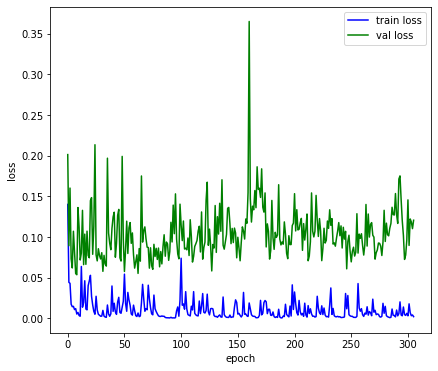

In [14]:
# Loss 시각화
plt.figure(figsize=(15, 6)) 
plt.subplot(1,2,1)
plt.ylabel('loss'); plt.xlabel('epoch')
plt.plot(train_loss, 'b', label='train loss')
plt.plot(val_loss, 'g', label='val loss')
plt.legend(loc='best')
plt.show()

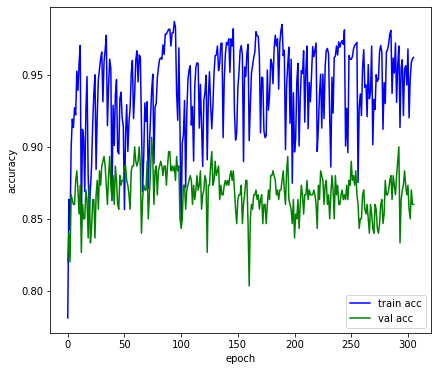

In [15]:
# Acc 시각화
plt.figure(figsize=(15, 6)) 
plt.subplot(1,2,1)
plt.ylabel('accuracy'); plt.xlabel('epoch')
plt.plot(train_acc, 'b', label='train acc')
plt.plot(val_acc, 'g', label='val acc')
plt.legend(loc='best')
plt.show()

# Test 데이터셋에 대한 결과

In [18]:
plt.show(); plt.close('all'); plt.clf()
model, optimizer, st_epoch = load(ckpt_dir=checkpoint_path_1, model=model, optim=optimizer)
print(st_epoch)

9


<Figure size 432x288 with 0 Axes>

tensor([1], device='cuda:0') tensor([0], device='cuda:0')


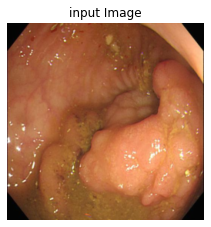

--------
tensor([1], device='cuda:0') tensor([0], device='cuda:0')


<Figure size 432x288 with 0 Axes>

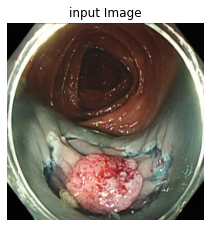

--------
tensor([1], device='cuda:0') tensor([0], device='cuda:0')


<Figure size 432x288 with 0 Axes>

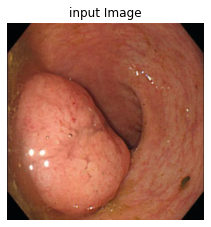

--------
tensor([3], device='cuda:0') tensor([0], device='cuda:0')


<Figure size 432x288 with 0 Axes>

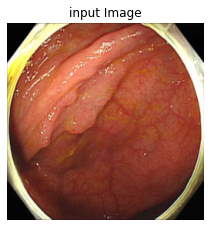

--------
tensor([1], device='cuda:0') tensor([0], device='cuda:0')


<Figure size 432x288 with 0 Axes>

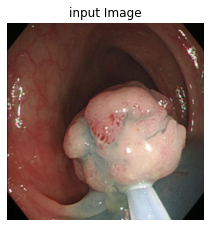

--------
tensor([1], device='cuda:0') tensor([0], device='cuda:0')


<Figure size 432x288 with 0 Axes>

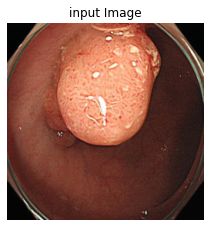

--------
tensor([1], device='cuda:0') tensor([0], device='cuda:0')


<Figure size 432x288 with 0 Axes>

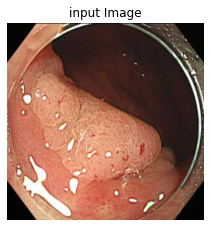

--------
tensor([1], device='cuda:0') tensor([0], device='cuda:0')


<Figure size 432x288 with 0 Axes>

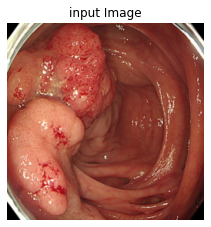

--------
tensor([2], device='cuda:0') tensor([1], device='cuda:0')


<Figure size 432x288 with 0 Axes>

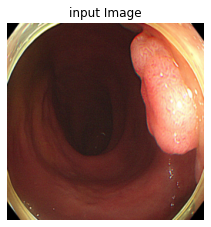

--------
tensor([0], device='cuda:0') tensor([1], device='cuda:0')


<Figure size 432x288 with 0 Axes>

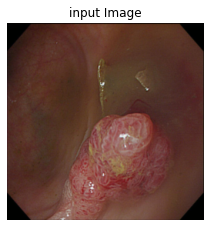

--------
tensor([0], device='cuda:0') tensor([1], device='cuda:0')


<Figure size 432x288 with 0 Axes>

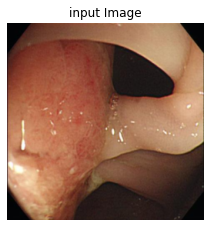

--------
tensor([0], device='cuda:0') tensor([1], device='cuda:0')


<Figure size 432x288 with 0 Axes>

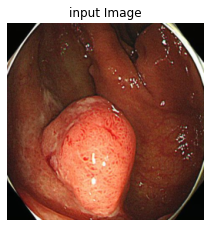

--------
tensor([0], device='cuda:0') tensor([1], device='cuda:0')


<Figure size 432x288 with 0 Axes>

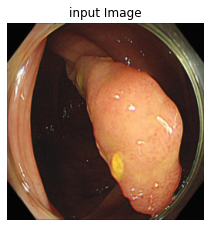

--------
tensor([2], device='cuda:0') tensor([1], device='cuda:0')


<Figure size 432x288 with 0 Axes>

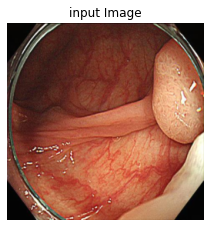

--------
tensor([0], device='cuda:0') tensor([1], device='cuda:0')


<Figure size 432x288 with 0 Axes>

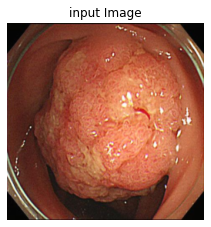

--------
tensor([0], device='cuda:0') tensor([1], device='cuda:0')


<Figure size 432x288 with 0 Axes>

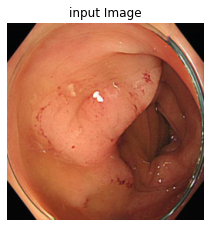

--------
tensor([2], device='cuda:0') tensor([1], device='cuda:0')


<Figure size 432x288 with 0 Axes>

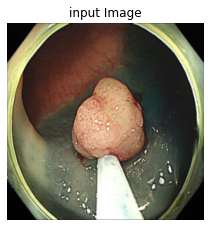

--------
tensor([2], device='cuda:0') tensor([1], device='cuda:0')


<Figure size 432x288 with 0 Axes>

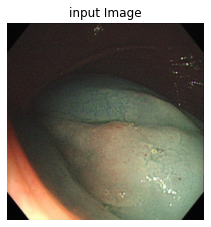

--------
tensor([1], device='cuda:0') tensor([2], device='cuda:0')


<Figure size 432x288 with 0 Axes>

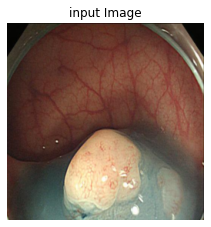

--------
tensor([1], device='cuda:0') tensor([2], device='cuda:0')


<Figure size 432x288 with 0 Axes>

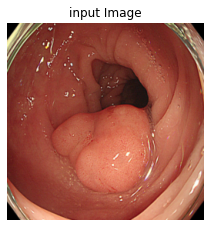

--------
tensor([1], device='cuda:0') tensor([2], device='cuda:0')


<Figure size 432x288 with 0 Axes>

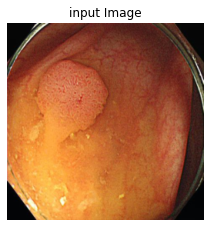

--------
tensor([1], device='cuda:0') tensor([2], device='cuda:0')


<Figure size 432x288 with 0 Axes>

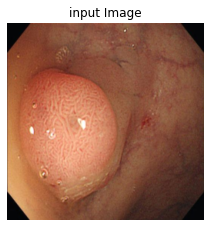

--------
tensor([1], device='cuda:0') tensor([2], device='cuda:0')


<Figure size 432x288 with 0 Axes>

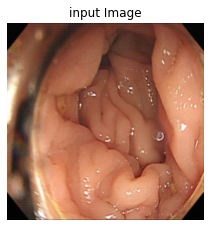

--------
tensor([0], device='cuda:0') tensor([2], device='cuda:0')


<Figure size 432x288 with 0 Axes>

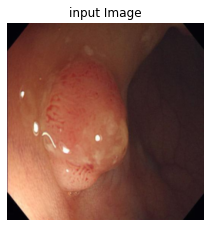

--------
tensor([1], device='cuda:0') tensor([2], device='cuda:0')


<Figure size 432x288 with 0 Axes>

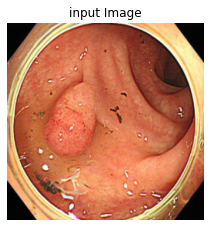

--------
tensor([1], device='cuda:0') tensor([2], device='cuda:0')


<Figure size 432x288 with 0 Axes>

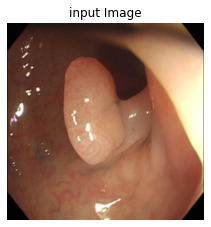

--------
tensor([2], device='cuda:0') tensor([3], device='cuda:0')


<Figure size 432x288 with 0 Axes>

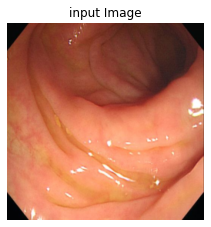

--------
Test Accuracy of the model on the 301 test images: 91.0299003322259%


<Figure size 432x288 with 0 Axes>

In [15]:
# Inference
total = correct = 0
model.eval()
with torch.no_grad():
    running_corrects = 0    
    for batch, item in enumerate(dataloaders['test'], 1):
        # if batch == 202:
        #     break
        inputs = item['input'].to(device)
        labels = item['label'].to(device)

        outputs = model(inputs)

        probs = nn.Softmax(dim=1)(outputs)
        predicts = torch.argmax(outputs, dim=1)

        total += len(labels)
        correct += (predicts == labels).sum().item()
        if (predicts == labels).sum().item() != 1:
            plt.figure(figsize=(12, 12))
            # 불러온 이미지 시각화
            input_image_example = plt.subplot(1,3,1)
            input_image_example.set_title('input Image')
            # # denormalize to show original image
            # mean=[0.590, 0.351, 0.259], std=[0.241, 0.199, 0.163]
            og = inputs.cpu().squeeze(0).permute(1,2,0).numpy()
            og[:,:,0] = ((og[:,:,0]) * 0.241) + 0.590
            og[:,:,1] = ((og[:,:,1]) * 0.199) + 0.351
            og[:,:,2] = ((og[:,:,2]) * 0.163) + 0.259
            plt.imshow(og)
            print(predicts, labels)
            plt.axis('off')
            plt.show()
            print("--------")
            plt.close('all')
            plt.clf()
        # print(probs, predicts, labels)
        # # 불러온 이미지 시각화
        # plt.figure(figsize=(12,12))
        # input_image_example = plt.subplot(1,3,1)
        # input_image_example.set_title(f'ADC: {100*pred_probs[0][3]:.2f}, HGD: {100*pred_probs[0][2]:.2f}, LGD: {100*pred_probs[0][1]:.2f}, NOR: {100*pred_probs[0][0]:.2f}')

        # plt.imshow(to_pil_image(changeTensor(inputs)))
        # print(outputs, labels, pred_probs)
        # print(f'NOR: {100*pred_probs[0][0]:.2f}, LGD: {100*pred_probs[0][1]:.2f}, HGD: {100*pred_probs[0][2]:.2f}, ADC: {100*pred_probs[0][3]:.2f}, ')
        # plt.show()
        # plt.close('all')
        # plt.clf()
    print('Test Accuracy of the model on the {} test images: {}%'.format(total, 100 * correct / total))

        

# Confusion matrix

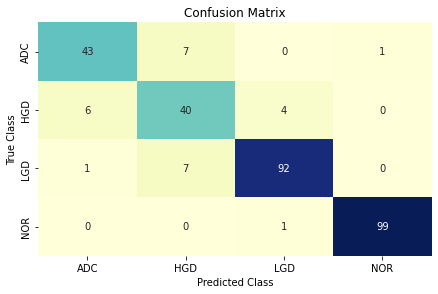

In [16]:
# ADC: 51, HGD:50, LGD:100, NOR:100
y_pred = []
y_true = []

# Inference
model.eval()
with torch.no_grad():
    for batch, item in enumerate(dataloaders['test'], 1):
        inputs = item['input'].to(device)
        labels = item['label'].to(device)

        outputs = model(inputs)
        outputs = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
        y_pred.extend(outputs) # save prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # save ground truth

class_names = ('ADC', 'HGD', 'LGD', 'NOR')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
# Create pandas dataframe
dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)

sn.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d")
plt.title("Confusion Matrix"), plt.tight_layout()
 
plt.ylabel("True Class"), 
plt.xlabel("Predicted Class")
plt.show()

In [17]:
from sklearn.metrics import classification_report
from pprint import pprint as pp

pp(classification_report(y_true, y_pred))

('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.86      0.84      0.85        51\n'
 '           1       0.74      0.80      0.77        50\n'
 '           2       0.95      0.92      0.93       100\n'
 '           3       0.99      0.99      0.99       100\n'
 '\n'
 '    accuracy                           0.91       301\n'
 '   macro avg       0.88      0.89      0.89       301\n'
 'weighted avg       0.91      0.91      0.91       301\n')


# Grad-CAM

In [ ]:
import cv2 

class FeatureExtractor():
    """ Class for extracting activations and 
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for name, module in self.model._modules.items():
            x = module(x)
            if name in self.target_layers:
                x.register_hook(self.save_gradient)
                outputs += [x]
        return outputs, x


class ModelOutputs():
    """ Class for making a forward pass, and getting:
    1. The network output.
    2. Activations from intermeddiate targetted layers.
    3. Gradients from intermeddiate targetted layers. """

    def __init__(self, model, feature_module, target_layers):
        self.model = model
        self.feature_module = feature_module
        self.feature_extractor = FeatureExtractor(self.feature_module, target_layers)

    def get_gradients(self):
        return self.feature_extractor.gradients

    def __call__(self, x):
        target_activations = []
        #print(x.shape)
        for name, module in self.model._modules.items():
            if module == self.feature_module:
                target_activations, x = self.feature_extractor(x)
            elif "avgpool" in name.lower():
                x = module(x)
                x = x.view(x.size(0),-1)
            else:
                x = module(x)
        
        return target_activations, x


def preprocess_image(img):
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    preprocessed_img = img.copy()[:, :, ::-1]
    for i in range(3):
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]
    preprocessed_img = \
        np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))
    preprocessed_img = torch.from_numpy(preprocessed_img)
    preprocessed_img.unsqueeze_(0)
    input = preprocessed_img.requires_grad_(True)
    return input


def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    os.path.join(base_dir, "cam.jpg")
    #cv2.imwrite("cam.jpg", np.uint8(255 * cam))
    cv2.imwrite(os.path.join(base_dir, "cam.jpg"), np.uint8(255 * cam))

class GradCam:
    def __init__(self, model, feature_module, target_layer_names, use_cuda):
        self.model = model
        self.feature_module = feature_module
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        self.extractor = ModelOutputs(self.model, self.feature_module, target_layer_names)

    def forward(self, input):
        return self.model(input)

    def __call__(self, input, index=None):
        if self.cuda:
            features, output = self.extractor(input.cuda())#[1, 2048, 7, 7], [1, 1000]
        else:
            features, output = self.extractor(input)


        if index == None:
            index = np.argmax(output.cpu().data.numpy())
        #print(index)

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)#1,1000
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
            print(one_hot)
        else:
            one_hot = torch.sum(one_hot * output)

        self.feature_module.zero_grad()
        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()#1, 2048, 7, 7
        target = features[-1]#1,2048,7,7
        target = target.cpu().data.numpy()[0, :]#2048, 7, 7

        weights = np.mean(grads_val, axis=(2, 3))[0, :]#2048
        cam = np.zeros(target.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):#w:weight,target:feature
            cam += w * target[i, :, :]

        cam = np.maximum(cam, 0)#7,7
        cam = cv2.resize(cam, input.shape[2:])#224,224
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

In [ ]:
# ADC_img_path = '/disk1/colonoscopy_dataset/cropped/ADC/'
# ADC_file_list = os.listdir(ADC_img_path) # ADC 전체 파일 목록
# ADC_data_list = sorted([x for x in ADC_file_list if 'IMG' in x])        # ADC data 파일 목록

grad_cam = GradCam(model=model, feature_module=model.layer4, target_layer_names=["2"], use_cuda=True)
# Inference
total = correct = 0
model.eval()

#with torch.no_grad():
running_corrects = 0
for item in ADC_data_list:
    path = os.path.join(ADC_img_path, item)
    img = cv2.imread(path, 1)
    img = np.float32(cv2.resize(img, (256, 256))) / 255
    input = preprocess_image(img)
    
    target_index = None
    mask = grad_cam(input, target_index)

    cam = show_cam_on_image(img, mask)